In [57]:
import pandas as pd
from datetime import date
from pathlib import Path 
import re
import geopandas as gpd
from ipyleaflet import Map, basemaps, CircleMarker
from ipywidgets import HTML


import sys
sys.path.append(str(Path.cwd().parent))

from scripts.normalize_data import print_df

In [8]:
paths = list(Path('..', 'processed_data', 'clean_data').rglob('*.csv'))

hole_path = Path('..', 'processed_data', 'Hole Summary_23_2_2021.csv')
taxa_search_path = Path('..', 'processed_data', 'taxa_list_search.csv')
nontaxa_list_path = Path('..', 'processed_data',  'normalized_nontaxa_list.csv')

## find matching taxa

In [32]:
search_terms = [
    'Globigerinoides',
    'Globorotalia'
]


In [33]:
taxa_list_df = pd.read_csv(taxa_search_path)
print_df(taxa_list_df)

(117, 3)


,verbatim_name,normalized_name,basic_name
0,Candeina nitida,Candeina nitida,Candeina nitida
1,Dentoglobigerina altispira _T_ _PL5,Dentoglobigerina altispira,Dentoglobigerina altispira
2,Dentoglobigerina altispira _T_ _PL5_,Dentoglobigerina altispira,Dentoglobigerina altispira
3,Dextral:Sinistral _P. obliquiloculata_,Pulleniatina obliquiloculata (dextral),Pulleniatina obliquiloculata
4,Dextral:Sinistral _P. obliquiloculata_,Pulleniatina obliquiloculata (sinistral),Pulleniatina obliquiloculata


In [34]:
taxa_matches = set()

for search_term in search_terms:     
    taxa_matches.update(list(taxa_list_df[taxa_list_df['normalized_name'].str.contains(fr"\b{search_term}\b",   regex=True)]['verbatim_name'] ))
    taxa_matches.update(list(taxa_list_df[taxa_list_df['basic_name'].str.contains(fr"\b{search_term}\b",   regex=True)]['verbatim_name'] ))
    
taxa_matches

{'Globigerinoides bulloideus',
 'Globigerinoides conglobatus',
 'Globigerinoides extremus _T and B',
 'Globigerinoides extremus _T and B_',
 'Globigerinoides fistulosus',
 'Globigerinoides obliquus _T',
 'Globigerinoides obliquus _T_',
 'Globigerinoides quadrilobatus',
 'Globigerinoides ruber',
 'Globigerinoides ruber (pink)',
 'Globigerinoides ruber (white)',
 'Globigerinoides ruber _pink_ T',
 'Globigerinoides ruber _pink_ _T_',
 'Globigerinoides sacculifer',
 'Globigerinoides sacculifer (without sack)',
 'Globigerinoides tenellus',
 'Globigerinoides trilobus',
 'Globorotalia (Globoconella) inflata',
 'Globorotalia (Globorotalia) tumida tumida',
 'Globorotalia (Hirsutella) hirsuta',
 'Globorotalia (Hirsutella) scitula',
 'Globorotalia (Truncorotalia) crossaformis',
 'Globorotalia (Truncorotalia) truncatulinoides',
 'Globorotalia anfracta',
 'Globorotalia crassaformis',
 'Globorotalia crassaformis sensu lato',
 'Globorotalia flexuosa',
 'Globorotalia flexuosa _T and B_',
 'Globorotali

## filter samples by taxa

In [35]:
nontaxa_list_df = pd.read_csv(nontaxa_list_path)
print_df(nontaxa_list_df)

(44, 2)


,field,normalized_field
0,A/W,A/W
1,Additional zone name,Additional zone name
2,Additional zone name (short),Additional zone name (short)
3,Bottom Depth [m],Bottom Depth [m]
4,Bottom Depth[m] [m],Bottom Depth [m]


In [36]:
cols = ['Exp', 'Site', 'Hole', 'Latitude_decimal', 'Longitude_decimal']
              
hole_df = pd.read_csv(hole_path, usecols=cols)
print_df(hole_df)

(3789, 5)


,Exp,Site,Hole,Latitude_decimal,Longitude_decimal
0,1,1,NaN,25.8583,-92.18330
1,1,2,NaN,23.4550,-92.58667
2,1,3,NaN,23.0300,-92.04330
3,1,4,NaN,24.4780,-73.79200
4,1,4,A,24.4780,-73.79200


In [37]:

hole_gdf = gpd.GeoDataFrame(
    hole_df, 
    geometry=gpd.points_from_xy(hole_df.Longitude_decimal, hole_df.Latitude_decimal)
)


print_df(hole_gdf)

(3789, 6)


,Exp,Site,Hole,Latitude_decimal,Longitude_decimal,geometry
0,1,1,NaN,25.8583,-92.18330,POINT (-92.18330 25.85830)
1,1,2,NaN,23.4550,-92.58667,POINT (-92.58667 23.45500)
2,1,3,NaN,23.0300,-92.04330,POINT (-92.04330 23.03000)
3,1,4,NaN,24.4780,-73.79200,POINT (-73.79200 24.47800)
4,1,4,A,24.4780,-73.79200,POINT (-73.79200 24.47800)


In [38]:
dfs = []

for path in paths:
    df = pd.read_csv(path, dtype=str)
    taxa_cols = set(df.columns).intersection(taxa_matches)
    if len(taxa_cols) > 0:
        nontaxa_cols = set(df.columns).intersection(set(nontaxa_list_df['field']))
        df = df[list(nontaxa_cols) + list(taxa_cols)]
        df['found_taxa'] = ','.join(taxa_cols)
 
        dfs.append(df)
    
search_df = pd.concat(dfs).reset_index(drop = True)
print_df(search_df)

(190, 99)


,Zone name (short),Zone name,Additional zone name,Group abundance,Top Depth [m],Bottom [cm],Top [cm],Additional zone name (short),Sample,Bottom Depth [m],...,Group abundance (%),Top[cm] [cm],Top Depth[m] [m],Globigerinoides ruber,Globorotalia (Hirsutella) hirsuta,Globorotalia (Globoconella) inflata,Globigerinoides quadrilobatus,Globorotalia (Truncorotalia) truncatulinoides,Globorotalia (Truncorotalia) crossaformis,Globorotalia (Globorotalia) tumida tumida
0,PT1b [W11],Globorotalia truncatulinoides Partial-range Zo...,NaN,D [A88],2.25,2,0,NaN,363-U1483A-1H-2-W 75/77-FORAM,2.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PT1b [W11],Globorotalia truncatulinoides Partial-range Zo...,NaN,D [A88],5.25,2,0,NaN,363-U1483A-1H-4-W 75/77-FORAM,5.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PT1b [W11],Globorotalia truncatulinoides Partial-range Zo...,NaN,D [A88],8.25,2,0,NaN,363-U1483A-1H-6-W 75/77-FORAM,8.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PT1b [W11],Globorotalia truncatulinoides Partial-range Zo...,NaN,D [A88],8.58,5,0,NaN,363-U1483A-1H-CC-PAL-FORAM,8.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PT1b [W11],Globorotalia truncatulinoides Partial-range Zo...,NaN,D [A88],10.84,2,0,NaN,363-U1483A-2H-2-W 74/76-FORAM,10.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
search_coor_df = search_df.merge(hole_gdf, on=['Exp', 'Site', 'Hole'])
print_df(search_coor_df)

(40, 102)


,Zone name (short),Zone name,Additional zone name,Group abundance,Top Depth [m],Bottom [cm],Top [cm],Additional zone name (short),Sample,Bottom Depth [m],...,Globigerinoides ruber,Globorotalia (Hirsutella) hirsuta,Globorotalia (Globoconella) inflata,Globigerinoides quadrilobatus,Globorotalia (Truncorotalia) truncatulinoides,Globorotalia (Truncorotalia) crossaformis,Globorotalia (Globorotalia) tumida tumida,Latitude_decimal,Longitude_decimal,geometry
0,NaN,NaN,NaN,abundant [A48],4.84,5,0,NaN,350-U1436B-1H-CC-PAL-FORAM,4.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.398267,140.365488,POINT (140.36549 32.39827)
1,NaN,NaN,NaN,abundant [A48],11.76,5,0,NaN,350-U1436B-2H-CC-PAL-FORAM,11.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.398267,140.365488,POINT (140.36549 32.39827)
2,NaN,NaN,NaN,abundant [A48],12.02,5,0,NaN,350-U1436B-3H-CC-PAL-FORAM,12.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.398267,140.365488,POINT (140.36549 32.39827)
3,NaN,NaN,NaN,abundant [A48],17.81,5,0,NaN,350-U1436B-4H-CC-PAL-FORAM,17.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.398267,140.365488,POINT (140.36549 32.39827)
4,NaN,NaN,NaN,few [A48],24.51,5,0,NaN,350-U1436B-5H-CC-PAL-FORAM,24.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.398267,140.365488,POINT (140.36549 32.39827)


## draw map

In [40]:
map_df = search_coor_df.drop_duplicates(subset=['Exp', 'Site', 'Hole'])
print_df(map_df)

(4, 102)


,Zone name (short),Zone name,Additional zone name,Group abundance,Top Depth [m],Bottom [cm],Top [cm],Additional zone name (short),Sample,Bottom Depth [m],...,Globigerinoides ruber,Globorotalia (Hirsutella) hirsuta,Globorotalia (Globoconella) inflata,Globigerinoides quadrilobatus,Globorotalia (Truncorotalia) truncatulinoides,Globorotalia (Truncorotalia) crossaformis,Globorotalia (Globorotalia) tumida tumida,Latitude_decimal,Longitude_decimal,geometry
0,NaN,NaN,NaN,abundant [A48],4.84,5,0,NaN,350-U1436B-1H-CC-PAL-FORAM,4.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.398267,140.365488,POINT (140.36549 32.39827)
15,CM1 [K00],N. Pachyderma B partial range zone (Kennett et...,NaN,R [A83],14.73,5,0,NaN,341-U1417B-2H-CC-PAL,14.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.959998,-147.109635,POINT (-147.10963 56.96000)
32,NaN,NaN,NaN,NaN,6.72,0,0,NaN,NaN,6.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.556927,-175.816585,POINT (-175.81659 57.55693)
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A[330],NaN,A[330],F[330],A[330],F[330],P[330],-28.595855,-173.380490,POINT (-173.38049 -28.59586)


In [59]:
m = Map(center=(0, 0), zoom=1 )


for index, hole in map_df.iterrows():
    print(hole["Latitude_decimal"], hole["Longitude_decimal"])
    # name = f'Exp: {hole["Exp"]},<br> Site: {hole["Site"]},<br> Taxa: {hole["found_taxa"]}'
    name = 'hi'
    marker = CircleMarker(
        location=(hole["Latitude_decimal"], hole["Longitude_decimal"]), 
        weight=1,
        radius=8
   
    )
    # marker.popup = HTML(value=name)

    
    m.add_layer(marker)
    
m.layout.height="400px"
# m.layout.width="400px"

m

32.398266666666665 140.36548833333333
56.95999833333333 -147.109635
57.55692666666667 -175.816585
-28.595855 -173.38049


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [47]:
print(m.bounds)

((-33.137551192346145, -71.01562500000001), (33.137551192346145, 71.19140625000001))


In [112]:
print(m.south, m.west, m.north, m.east)


-8.407168163601076 69.08203125000001 52.482780222078226 197.92968750000003


In [113]:
geom = gpd.points_from_xy(map_df['Longitude_decimal'], map_df['Latitude_decimal'])
gdf_points = gpd.GeoDataFrame(geometry=geom, crs='epsg:4326')

gdf_points.shape

(4, 1)

In [114]:
# gdf_points.cx[xmin:xmax, ymin:ymax]
gdf_points.cx[m.east:m.west, m.north:m.south]

,geometry
0,POINT (91.60563 3.03390)
1,POINT (140.36549 32.39827)


In [109]:
foo['lon'] = foo['geometry'].x
foo['lat'] = foo['geometry'].y

foo

,geometry,lon,lat
0,POINT (91.60563 3.03390),91.605630,3.033902
1,POINT (91.60563 3.03390),91.605630,3.033902
2,POINT (91.60563 3.03390),91.605630,3.033902
3,POINT (91.60563 3.03390),91.605630,3.033902
4,POINT (91.60563 3.03390),91.605630,3.033902
5,POINT (91.60563 3.03390),91.605630,3.033902
6,POINT (91.60563 3.03390),91.605630,3.033902
7,POINT (91.60563 3.03390),91.605630,3.033902
8,POINT (91.60563 3.03390),91.605630,3.033902
9,POINT (91.60563 3.03390),91.605630,3.033902


(15, 71)
(10, 1)


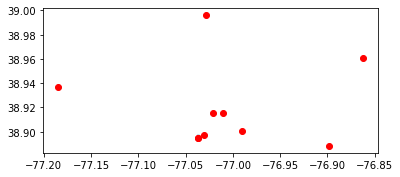

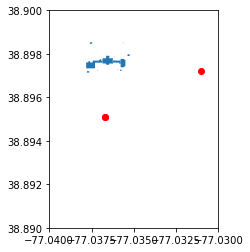

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox # handle open street map
import pandas as pd

# the coordinates you provided
df = pd.DataFrame({'lat': [38.897221,38.888100,38.915390,38.895100,38.895100,38.901005,38.960491,38.996342,38.915310,38.936820],
                   'lng': [-77.031048,-76.898480,-77.021380,-77.036700,-77.036700   ,-76.990784,-76.862907,-77.028131,-77.010403,-77.184930]})

# create GeoDataFrame of point geometries
geom = gpd.points_from_xy(df['lng'], df['lat'])
gdf_points = gpd.GeoDataFrame(geometry=geom, crs='epsg:4326')

# get building footprints
tags = {"building": True}
gdf_bldgs = ox.geometries_from_point([38.8977, -77.0365], tags, dist=100)
print(gdf_bldgs.shape)

# get all points that are not within a building footprint
mask = gdf_points.within(gdf_bldgs.unary_union)
gdf_points_not_in_bldgs = gdf_points[~mask]
print(gdf_points_not_in_bldgs.shape)  # (10, 1)

# plot buildings and points
ax = gdf_bldgs.plot()
ax = gdf_points.plot(ax=ax, c='r')
plt.show()

# zoom in to see better
ax = gdf_bldgs.plot()
ax = gdf_points.plot(ax=ax, c='r')
ax.set_xlim(-77.04, -77.03)
ax.set_ylim(38.89, 38.90)
plt.show()